# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code from [lecture 5](https://numeconcopenhagen.netlify.com/lectures/Workflow_and_debugging).
> 1. Remember this [guide](https://www.markdownguide.org/basic-syntax/) on markdown and (a bit of) latex.
> 1. Turn on automatic numbering by clicking on the small icon on top of the table of contents in the left sidebar.
> 1. The `dataproject.py` file includes a function which will be used multiple times in this notebook.

Imports and set magics:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2 
import numpy as np
# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import dataproject

# import pydst
import pydst
dst = pydst.Dst(lang='en')

# Read and clean data

## Employment data

**Read the employment data** in ``RAS200.xlsx`` and **clean it** removing and renaming columns:

In [2]:
educ_vars = dst.get_variables(table_id='HFUDD10')
educ_vars

#a. Download data
educ = dst.get_data(table_id = 'HFUDD10', variables={'Tid':['*'],'HERKOMST':['*'], 'HFUDD':['TOT','H30', 'H40','H50','H60','H70'], 'KØN':['*']})
educ.head(10)

# b. drop columns
drop_these = ['BOPOMR','ALDER']
educ.drop(drop_these, axis=1, inplace=True)

# c. rename columns
educ.rename(columns = {'HERKOMST':'Ancestry', 'KØN':'Gender', 'TID':'Year', 'HFUDD':'HCEDUC', 'INDHOLD':'Units'}, inplace=True)

educ['HCEDUC']=educ.HCEDUC.astype(str).str[4:]


# d. Set index to year
educ.set_index('Year')
educ.head()

,Year,Ancestry,HCEDUC,Gender,Units
0,2006,Descendant,Vocational Education and Training (VET),Women,1938
1,2006,Descendant,Vocational Education and Training (VET),Men,1756
2,2006,Descendant,Vocational Education and Training (VET),Total,3694
3,2006,Descendant,Short cycle higher education,Women,314
4,2006,Descendant,Short cycle higher education,Men,370


In [3]:
educ1 = educ.copy()

for val in ['Men', 'Women']: 
    I = educ1.Gender.str.contains(val)
    educ1 = educ1.loc[I == False] # keep everything else

# a. split
educ_grouped = educ.groupby(['Ancestry', 'Gender'])
educ_grouped_first = educ_grouped.Units.first()
educ_grouped_first.name = 'first'

# b. apply
educ1.set_index(['Ancestry','Gender','Year'],inplace=True)
educ1 = educ1.join(educ_grouped_first,how='left',on=['Ancestry','Gender'])
educ1.reset_index(inplace=True)

# c. combine
educ1['indexed'] = educ1['Units']/educ1['first']

# d. plot
def plot_index(dataframe, Educations):
    dataframe_indexed = dataframe.set_index(['Year'])
    I = dataframe_indexed.HCEDUC == Educations
    dataframe_indexed[I].groupby(['Ancestry'])['indexed'].plot(legend=True);
    
def plot_index_i(dataframe):
    widgets.interact(plot_index, dataframe = widgets.fixed(dataframe), 
    Educations=widgets.Dropdown(decription='Education', options=dataframe.HCEDUC.unique())
); 
    
#plot_index_i(educ1)
plot_index_i(educ1)

interactive(children=(Dropdown(description='Educations', options=('Vocational Education and Training (VET)', '…

In [81]:
pop = dst.get_data(table_id = 'FOLK1C', variables={'Tid':['*'], 'HERKOMST':['*'], 'KØN':['*']})

drop_these = drop_these = ['OMRÅDE','ALDER', 'IELAND']
pop.drop(drop_these, axis=1, inplace=True)

pop.rename(columns = {'HERKOMST':'Ancestry', 'KØN':'Gender', 'TID':'Year','INDHOLD':'Pop'}, inplace=True)

for val in ['Q2','Q3','Q4']: 
    I = pop.Year.str.contains(val)
    pop.drop(pop[I].index, inplace=True)


pop.Year.astype(str)
pop['Year']= pop.Year.astype(str).str[:4]
pop.head()

pop.Year = pop.Year.astype(int)
pop.dtypes
merged = pd.merge(educ, pop, how='inner',on=['Year','Ancestry','Gender'])
merged.head()


,Year,Ancestry,HCEDUC,Gender,Units,Pop
0,2008,Descendant,Vocational Education and Training (VET),Women,2273,58393
1,2008,Descendant,Short cycle higher education,Women,395,58393
2,2008,Descendant,Vocational bachelors educations,Women,1048,58393
3,2008,Descendant,Bachelors programmes,Women,397,58393
4,2008,Descendant,Masters programmes,Women,610,58393


In [82]:
for val in ['Masters programmes']: 
    I = educ.HCEDUC.str.contains(val)
    educ = educ.loc[I == True] # keep everything else
educ.head()

,Year,Ancestry,HCEDUC,Gender,Units
12,2006,Descendant,Masters programmes,Women,468
13,2006,Descendant,Masters programmes,Men,569
14,2006,Descendant,Masters programmes,Total,1037
30,2006,Immigrants,Masters programmes,Women,9166
31,2006,Immigrants,Masters programmes,Men,11186


/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:209: UserWarning: tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes height small enough '


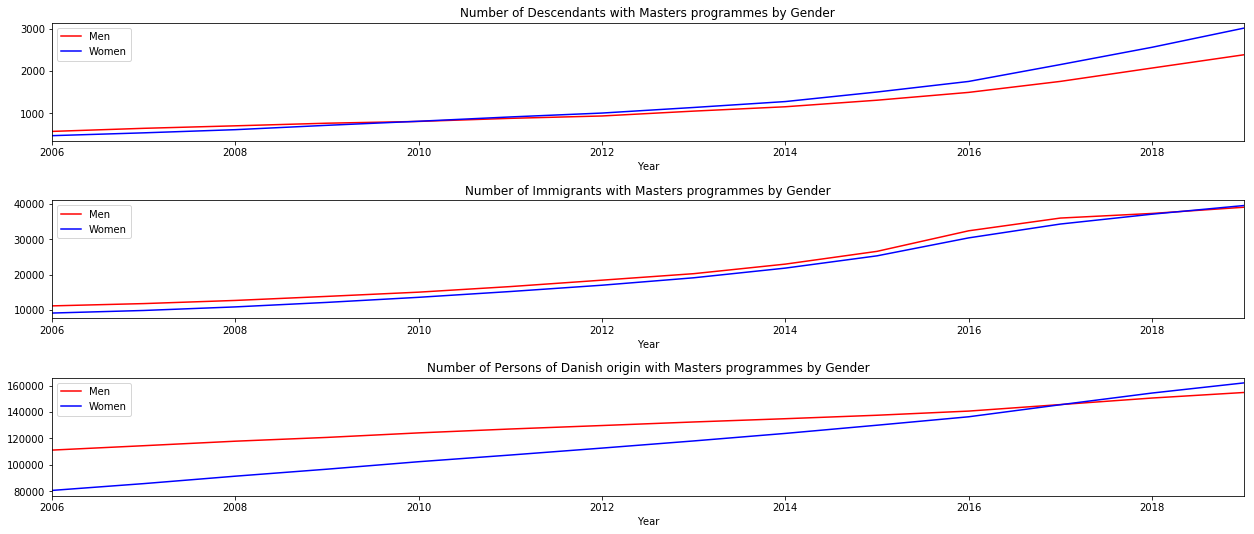

In [26]:

plt.figure(figsize=(20,10))

educ2 = educ.copy()
I = educ2.Ancestry == 'Descendant'
x = educ2[I]

ax = plt.subplot(311)

J = x.Gender == 'Men'
y1 = x[J]
y1.rename(columns = {'Units':'Men'}, inplace=True)
y1.plot(kind='line', x = 'Year', y='Men', color='red', ax=ax)

K = x.Gender == 'Women'
y2 = x[K]
y2.rename(columns = {'Units':'Women'}, inplace=True)
y2.plot(kind='line', x = 'Year', y='Women', color='blue', ax=ax)
ax.set_title('Number of Descendants with Masters programmes by Gender')


educ3 = educ.copy()
I = educ3.Ancestry == 'Immigrants'
x = educ3[I]

ax1 = plt.subplot(312)

J = x.Gender == 'Men'
y1 = x[J]
y1.rename(columns = {'Units':'Men'}, inplace=True)
y1.plot(kind='line', x = 'Year', y='Men', color='red', label='Men', ax=ax1)

K = x.Gender == 'Women'
y2 = x[K]
y2.rename(columns = {'Units':'Women'}, inplace=True)
y2.plot(kind='line', x = 'Year', y='Women', color='blue', ax=ax1, label='Women')
ax1.set_title('Number of Immigrants with Masters programmes by Gender')


educ4 = educ.copy()
I = educ4.Ancestry == 'Persons of Danish origin'
x = educ4[I]

ax2 = plt.subplot(313)

J = x.Gender == 'Men'
y1 = x[J]
y1.rename(columns = {'Units':'Men'}, inplace=True)
y1.plot(kind='line', x = 'Year', y='Men', color='red', ax=ax2)

K = x.Gender == 'Women'
y2 = x[K]
y2.rename(columns = {'Units':'Women'}, inplace=True)
y2.plot(kind='line', x = 'Year', y='Women', color='blue', ax=ax2)
ax2.set_title('Number of Persons of Danish origin with Masters programmes by Gender')


plt.tight_layout(pad=10,h_pad=20,w_pad=20)

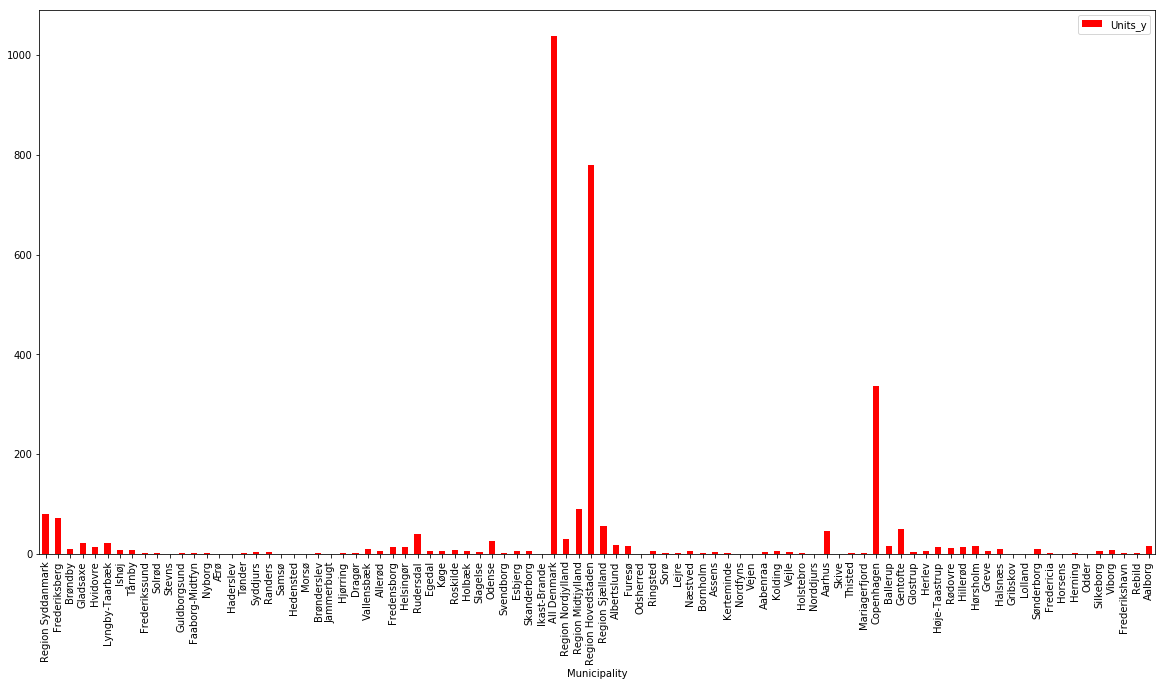

In [37]:
mp= dst.get_data(table_id = 'HFUDD10', variables={'Tid':['*'],'HERKOMST':['*'], 'HFUDD':['H70'], 'KØN':['*'], 'BOPOMR':['*']})
mp.head()


# b. drop columns
drop_these = ['ALDER', 'HFUDD']
mp.drop(drop_these, axis=1, inplace=True)

# c. rename columns
mp.rename(columns = {'HERKOMST':'Ancestry', 'KØN':'Gender', 'TID':'Year', 'INDHOLD':'Units', 'BOPOMR':'Municipality'}, inplace=True)
mp.head(10)

# d. Set index to year
mp.set_index('Year')

merged = pd.merge(educ, mp, how='inner',on=['Year','Ancestry','Gender'])
merged.head()

plt.figure(figsize=(20,10))
ax = plt.subplot()
I = merged.Gender == 'Total'
x = merged[I]
J = x.Year == 2006
y1 = x[J]
K = y1.Ancestry == 'Descendant'
y11 = y1[K]
y11.plot(kind='bar', x = 'Municipality', y='Units_y', color='red', ax=ax)

## Income data

**Read the income data** in ``INDKP101.xlsx`` and **clean it**:

In [ ]:
# a. load
#inc = pd.read_excel('INDKP101.xlsx', skiprows=2)

# b. drop and rename columns
#inc.drop([f'Unnamed: {i}' for i in range(3)], axis=1, inplace=True)
#inc.rename(columns = {'Unnamed: 3':'municipality'}, inplace=True)

# c. drop rows with missing
#inc.dropna(inplace=True)

# d. remove non-municipalities
#inc = dataproject.only_keep_municipalities(inc)

# e. convert to long
#inc.rename(columns = {str(i):f'income{i}' for i in range(1986,2018)}, inplace=True)
#inc_long = pd.wide_to_long(inc, stubnames='income', i='municipality', j='year').reset_index()

# f. show
#inc_long.head(5)

> **Note:** The function ``dataproject.only_keep_municipalities()`` is used on both the employment and the income datasets.

## Explore data set

In order to be able to **explore the raw data**, we here provide an **interactive plot** to show, respectively, the employment and income level in each municipality

The **static plot** is:

In [ ]:
def plot_empl_inc(empl,inc,dataset,municipality): 
    
    if dataset == 'Employment':
        df = empl
        y = 'employment'
    else:
        df = inc
        y = 'income'
    
    I = df['municipality'] == municipality
    ax = df.loc[I,:].plot(x='year', y=y, style='-o')

The **interactive plot** is:

In [ ]:
widgets.interact(plot_empl_inc, 
    
    empl = widgets.fixed(empl_long),
    inc = widgets.fixed(inc_long),
    dataset = widgets.Dropdown(description='Dataset', 
                               options=['Employment','Income']),
    municipality = widgets.Dropdown(description='Municipality', 
                                    options=empl_long.municipality.unique())
                 
); 

ADD SOMETHING HERE IF THE READER SHOULD KNOW THAT E.G. SOME MUNICIPALITY IS SPECIAL.

# Merge data sets

We now create a data set with **municpalities which are in both of our data sets**. We can illustrate this **merge** as:

In [ ]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('inc', 'empl'))
v.get_label_by_id('100').set_text('dropped')
v.get_label_by_id('010').set_text('dropped' )
v.get_label_by_id('110').set_text('included')
plt.show()

In [ ]:
merged = pd.merge(empl_long, inc_long, how='inner',on=['municipality','year'])

print(f'Number of municipalities = {len(merged.municipality.unique())}')
print(f'Number of years          = {len(merged.year.unique())}')

# Analysis

To get a quick overview of the data, we show some **summary statistics by year**:

In [ ]:
merged.groupby('year').agg(['mean','std']).round(2)

ADD FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.